In [1]:
import gymnasium as gym
# import Lorenz_envs
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import warnings
import copy 
import wandb
import le_envs

from IPython import display
from torch.distributions import MultivariateNormal
from torch.optim import Adam
from torch.nn import Linear, Module, MSELoss, ReLU, Sequential

warnings.filterwarnings("ignore")

## Feed-Forward Network

In [2]:
class PolicyNetwork(Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.model = Sequential(
            Linear(input_dim, 64),
            ReLU(),
            Linear(64, 64),
            ReLU(),
            Linear(64, output_dim)
        )
    
    def forward(self, observation):
        if isinstance(observation, np.ndarray):
            observation = torch.tensor(observation, dtype=torch.float)
        return self.model(observation)

## Reward Functions

In [3]:
class RewardStrategy:
    def __init__(self, gamma, gae_lambda):
        self.gamma = gamma
        self.gae_lambda = gae_lambda

class RewardsToGo(RewardStrategy):
    def __init__(self, gamma, gae_lambda):
        super().__init__(gamma, gae_lambda)

    def compute_advantages(self, rewards, values, masks):
        batch_rtgs = []
        for episode_rewards in reversed(rewards):
            discounted_reward = 0
            for reward in reversed(episode_rewards):
                discounted_reward = reward + discounted_reward * self.gamma
                batch_rtgs.insert(0, discounted_reward)
        
        batch_rtgs = torch.tensor(batch_rtgs, dtype=torch.float)
        adv = batch_rtgs - values
        return batch_rtgs, adv

class GeneralizedAdvantage(RewardStrategy):
    def __init__(self, gamma, gae_lambda):
        super().__init__(gamma, gae_lambda)
        self.coeff = gamma * gae_lambda

    def compute_advantages(self, rewards, values, masks):
        flat_rewards = torch.flatten(rewards)
        batch_size = len(flat_rewards)
        advantage = np.zeros(batch_size + 1)
        advantage[batch_size - 1] = flat_rewards[batch_size - 1] - values[batch_size - 1]

        for i in reversed(range(batch_size - 1)):
            delta = flat_rewards[i] + (masks[i] * self.gamma * values[i + 1]) - values[i]
            advantage[i] = delta + (masks[i] * self.coeff * advantage[i + 1])
        
        advantage = torch.tensor(advantage[:batch_size])
        batch_returns = advantage + np.squeeze(values)
        batch_returns = torch.tensor(batch_returns, dtype=torch.float)
        return batch_returns, advantage

## Objective Functions

In [4]:
class Objective:
    def __init__(self, epsilon):
        self.epsilon = epsilon

class SurrogateObjectiveClip(Objective):
    def __init__(self, epsilon):
        super().__init__(epsilon)

    def get_loss(self, ratios, advantage):
        surrogate_loss = ratios * advantage
        clipped_surrogate_loss = torch.clamp(ratios, 1 - self.epsilon, 1 + self.epsilon) * advantage

        return (-torch.min(surrogate_loss, clipped_surrogate_loss)).mean()

class SurrogateObjectiveNoClip(Objective):
    def __init__(self, epsilon):
        super().__init__(epsilon)

    def get_loss(self, ratios, advantage):
        surrogate_loss = ratios * advantage

        return (-torch.min(surrogate_loss)).mean()

In [5]:
import os

In [6]:
os.environ["WANDB_API_KEY"] = "8ccd1d495e090b278b30893e97ce564ec9ff7621"

In [6]:
# wandb.login(relogin=True)
wandb.login()

wandb: Currently logged in as: phuchau1110. Use `wandb login --relogin` to force relogin


True

## PPO

In [7]:
class PPO:
    def __init__(self, env, policy_class, reward_class, objective_class, seed: int = 260):
        # Initialize hyperparameters
        self.timesteps_per_batch = 100000
        self.max_timesteps_per_episode = 200
        self.updates_per_iteration = 5
        self.lr = 3e-4
        self.gamma = 0.99
        self.gae_lambda = 0.95
        self.epsilon = 0.2
        self.critic_discount = 0.5
        self.alpha = 0.001
        self.seed = seed
        self.dt = 0.05
        
        
        torch.manual_seed(self.seed)

        self.config = {
            "timesteps_per_batch": self.timesteps_per_batch,
            "max_timesteps_per_episode": self.max_timesteps_per_episode,
            "updates_per_iteration": self.updates_per_iteration,
            "lr": self.lr,
            "gamma": self.gamma,
            "gae_lambda": self.gae_lambda,
            "epsilon": self.epsilon,
            "critic_discount": self.critic_discount,
            "alpha": self.alpha,
            "dt": self.dt
        }
        
        wandb.init(
          # Set the project where this run will be logged
          project="ppo_testing", 
          # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
          name="experiment_10_withaction", 
          # Track hyperparameters and run metadata
          config=self.config)
        
        # Initialize other parameters
        self.render = False
        self.render_interval = 10

        # Set environment params
        self.env = env
        self.env1 = copy.deepcopy(self.env)
        self.observation_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.shape[0]

        # Initialize networks
        self.actor = policy_class(self.observation_dim, self.action_dim)
        self.critic = policy_class(self.observation_dim, 1)
        self.critic1 = policy_class(self.observation_dim, 1)

        # Initialize advantage and objective functions
        self.reward_strategy = reward_class(self.gamma, self.gae_lambda)
        self.objective = objective_class(self.epsilon)

        # Initialize optimizers
        self.actor_optimizer = Adam(self.actor.parameters(), lr=self.lr)
        self.critic_optimizer = Adam(self.critic.parameters(), lr=self.lr)
        self.critic_optimizer1 = Adam(self.critic1.parameters(), lr=self.lr)

        # Initialize covariance matrix
        self.cov_matrix = torch.diag(torch.full(size=(self.action_dim,), fill_value=0.5))
        
        # Initialize logger
        self.logger = {
            "delta_time": time.time_ns(),
            "current_timesteps": 0,
            "current_iterations": 0,
            "batch_lens": [],
            "batch_rewards": [],
            "actor_losses": [],
            "total_losses": [],
            "theta": [],
            "theta_dot": [],
            "reward": []
        }

        # Initialize results
        self.results = {
            "iteration_count": [],
            "accumulated_rewards": [],
            "total_losses": [],
            "theta": [],
            "theta_dot": [],
            "reward": []
        }
        

    def train(self, max_timesteps):
        current_timesteps, current_iterations = 0, 0
        while current_timesteps < max_timesteps:
            # Run batch simulations (set of trajectories from running policy in the environment)
            batch, batch1 = self.batch_simulation()
            batch_obs, batch_acts, batch_log_probs, batch_rewards, batch_lens, batch_masks = batch
            batch_obs1, batch_acts1, batch_log_probs1, batch_rewards1, batch_lens1, batch_masks1 = batch1
            
#             batch_rewards = batch_rewards + batch_rewards1
#             print (batch_rewards)
#             input()
            # Increment timesteps and iterations
            current_timesteps += np.sum(batch_lens)
            current_iterations += 1
            self.logger["current_timesteps"] = current_timesteps
            self.logger["current_iterations"] = current_iterations

            # Calculate returns and advantages
            values, _ = self.evaluate(batch_obs, batch_acts)
            values1, _ = self.evaluate(batch_obs1, batch_acts1)
#             print ('batch_rewards:', batch_rewards)
#             print ('values.detach():', values.detach())
#             print ('batch_masks:', batch_rewards)
            batch_returns, adv = self.reward_strategy.compute_advantages(batch_rewards, values.detach(), batch_masks)
            batch_returns1, adv1 = self.reward_strategy.compute_advantages(batch_rewards1, values1.detach(), batch_masks1)
            # Normalize advantages
            adv = (adv - adv.mean()) / (adv.std() + 1e-10)
            adv1 = (adv1 - adv1.mean()) / (adv1.std() + 1e-10)
            # Update the networks
            for _ in range(self.updates_per_iteration):
                V_phi, log_probs = self.evaluate(batch_obs, batch_acts)
                policy_ratios = torch.exp(log_probs - batch_log_probs)
                
                V_phi1, log_probs1 = self.evaluate(batch_obs1, batch_acts1)
                policy_ratios1 = torch.exp(log_probs1 - batch_log_probs1)
                
                # Calculate actor and critic losses
#                 print ('loss:',self.objective.get_loss(policy_ratios, adv))
#                 input()
                # torch.cat((losses_q.reshape(1), this_loss_q), dim=0)
#                 actor_loss  = torch.mean(torch.cat((self.objective.get_loss(policy_ratios, adv).reshape(1), self.objective.get_loss(policy_ratios1, adv1).reshape(1)),0))
                actor_loss  = self.objective.get_loss(policy_ratios, adv)
                critic_loss = MSELoss()(V_phi, batch_returns)
#                 critic_loss1 = MSELoss()(V_phi1, batch_returns1)
                
                # Calculate gradients and perform backward propagation for actor/critic networks
                self.actor_optimizer.zero_grad()
                actor_loss.backward(retain_graph=True)
                self.actor_optimizer.step()
                
                self.critic_optimizer.zero_grad()
                critic_loss.backward()
                self.critic_optimizer.step()
                
#                 self.critic_optimizer1.zero_grad()
#                 critic_loss1.backward()
#                 self.critic_optimizer1.step()
                
                self.logger["actor_losses"].append(actor_loss.detach())
                self.logger["total_losses"].append(actor_loss.detach() + self.critic_discount * critic_loss.detach())

            self._log_summary()

    def batch_simulation(self):
        batch_obs = []
        batch_acts = []
        batch_log_probs = []
        batch_rewards = []
        batch_lens = []
        batch_masks = []
        theta = []
        theta_dot = []
        
        
        batch_obs1 = []
        batch_acts1 = []
        batch_log_probs1 = []
        batch_rewards1 = []
        batch_masks1 = []
        

        current_iteration = self.logger["current_iterations"]
        t = 0
        while t < self.timesteps_per_batch:
            episode_rewards = []
            episode_rewards1 = []
            
            observation, info = self.env.reset(goal=[0,0,0])
            observation1, info1 = self.env1.reset(goal=[0,0,0])
            observation1 = observation
            
            is_done = False
            is_done1 = False
            
            episode_t = 0
            temp_obs = self.convert_to_rad(observation)
            theta.append(temp_obs[0])
            theta_dot.append(temp_obs[1])
            
            # Run an episode
            for episode_t in range(self.max_timesteps_per_episode):
                if self.render and len(batch_lens) == 0 and (current_iteration % self.render_interval == 0):
                    self.env.render()
                
                # Calculate an action and make that action in the environment
                s1 = observation                
                # print (observation)
                # input()
                batch_obs.append(observation)
                action, log_prob = self.get_action(observation)
                observation, reward, is_done, truncated, info = self.env.step(action)
                s11 = observation
                
                # Track rewards, actions, and log probs
                batch_acts.append(action)
                batch_log_probs.append(log_prob)
                batch_masks.append(0 if is_done else 1)
                
                # Calculate an action and make that action in the environment
                s2 = observation1
                batch_obs1.append(observation1)
                action1, log_prob1 = self.get_action(observation1)
                observation1, reward1, is_done1, truncated1, info1 = self.env1.step(action1)
                s21 = observation1
                
                # Track rewards, actions, and log probs
                reward, reward1 = self.le_reward(s1, s11, s2, s21, action, action1)
                episode_rewards.append(reward)
                episode_rewards1.append(reward1)
                batch_acts1.append(action1)
                batch_log_probs1.append(log_prob1)
                batch_masks1.append(0 if is_done1 else 1)
                
                
 
                t += 1
                if is_done or is_done1:
                    break
#             print (episode_t)
#             print (is_done,is_done1)
#             input()
            batch_lens.append(episode_t + 1)
            batch_rewards.append(episode_rewards)
            batch_rewards1.append(episode_rewards1)

        
        # Cast everything we need to a tensor
        batch_obs = torch.tensor(batch_obs, dtype=torch.float)
        batch_acts = torch.tensor(batch_acts, dtype=torch.float)
        batch_log_probs = torch.tensor(batch_log_probs, dtype=torch.float)
        batch_rewards = torch.tensor(batch_rewards, dtype=torch.float)
        batch_masks = torch.tensor(batch_masks, dtype=torch.float)
        
        batch_obs1 = torch.tensor(batch_obs1, dtype=torch.float)
        batch_acts1 = torch.tensor(batch_acts1, dtype=torch.float)
        batch_log_probs1 = torch.tensor(batch_log_probs1, dtype=torch.float)
        batch_rewards1 = torch.tensor(batch_rewards1, dtype=torch.float)
        batch_masks1 = torch.tensor(batch_masks1, dtype=torch.float)

        self.logger["batch_rewards"] = batch_rewards
        self.logger["batch_lens"] = batch_lens
        self.logger["theta"] = theta
        self.logger["theta_dot"] = theta_dot

        return [batch_obs, batch_acts, batch_log_probs, batch_rewards, batch_lens, batch_masks], [batch_obs1, batch_acts1, batch_log_probs1, batch_rewards1, batch_lens, batch_masks1]
    
    def le_reward (self, s1, s11, s2, s21, a1, a2):
#         print ('before')
#         print ("s1:", s1)
#         print ("s2:", s2)
#         print ("s11:", s11)
#         print ("s21:", s21)
        if np.array_equal(s1, s2):
            s2 = s2+1e-4
        temp = [s1, s11, s2, s21]
        s1 = self.convert_to_rad(s1)
        s11 = self.convert_to_rad(s11)
        s2 = self.convert_to_rad(s2)
        s21 = self.convert_to_rad(s21)
        temp2 = [s1, s11, s2, s21]
#         if np.any(np.isnan(s1)) or np.any(np.isnan(s11)) or np.any(np.isnan(s2)) or np.any(np.isnan(s21)):
#             print ("s1:", s1)
#             print ("s2:", s2)
#             print ("s11:", s11)
#             print ("s21:", s21)
#         if np.any(np.isnan(s1)):
#             print ('after')
#             print ("s1:", s1)
#             print ("s2:", s2)
#             print ("s11:", s11)
#             print ("s21:", s21)
        #GS for s
        norm1 = np.linalg.norm(s1)
        s1 = s1/norm1
        
        GSC1 = np.dot(s2, s1)
        s2 = s2 - GSC1*s1
        
        norm2 = np.linalg.norm(s2)
#         s2 = s2/norm2
        
        #GS for s1
        norm11 = np.linalg.norm(s11)
        s11 = s11/norm11
        
        GSC1 = np.dot(s21, s11)
        s21 = s21 - GSC1*s11
        
        norm21 = np.linalg.norm(s21)
#         s21 = s21/norm21
        if np.log(norm11/norm1) ==np.inf or np.log(norm21/norm2) == np.inf:
            print ('temp:', temp)
            print ('temp2:', temp2)
            print ("s1:", s1)
            print ("s2:", s2)
            print ("s11:", s11)
            print ("s21:", s21)
            print ("lamda1:", np.log(norm11/norm1))
            print ("lamda2:", np.log(norm21/norm2))
#         print ("norm11:", norm11)
#         print ("norm21:", norm21)
#         return 2*np.log(norm11/norm1) - self.alpha*action**2, np.log(norm21/norm2)
        return np.log(norm11/norm1) - self.alpha*a1**2, np.log(norm21/norm2) - self.alpha*a2**2
    
    def convert_to_rad(self,s):
        return np.array([np.arctan2(s[0],s[1]),s[2]])
    
    def evaluate(self, observations, actions):
        # Calculate the values of each observation
        values = self.critic(observations).squeeze()

        # Calculate the log probabilities of each action
        mean = self.actor(observations)
#         print (values,observations)
#         input()
        distribution = MultivariateNormal(mean, self.cov_matrix)
        log_probs = distribution.log_prob(actions)

        return values, log_probs
    
    def get_action(self, observation):
        # Sample the distribution for an action
        mean = self.actor(observation)
        distribution = MultivariateNormal(mean, self.cov_matrix)
        action = distribution.sample()

        # Calculate the log probability for the sampled action
        log_prob = distribution.log_prob(action)

        return action.detach().numpy(), log_prob.detach()

    def get_results(self):
        return self.results

    def _log_summary(self):
        delta_t = self.logger["delta_time"]
        self.logger["delta_time"] = time.time_ns()
        delta_t = str(round((self.logger["delta_time"] - delta_t) / 1e9, 2))

        # Calculate everything we want to log
        current_timestep = self.logger["current_timesteps"]
        current_iteration = self.logger["current_iterations"]
#         print (self.logger["batch_lens"])
#         input()
        avg_ep_lens = np.mean(self.logger["batch_lens"])
        avg_ep_rewards = np.mean([np.sum(np.array(ep_rewards)) for ep_rewards in self.logger["batch_rewards"]])
        avg_actor_loss = np.mean([losses.float().mean() for losses in self.logger["actor_losses"]])
        avg_total_loss = np.mean([losses.float().mean() for losses in self.logger["total_losses"]])
#         print(self.logger["batch_rewards"])
        mean_each_traj = np.mean(np.array(self.logger["batch_rewards"]), axis=1)
        # Print logging statements
        display.clear_output()
        print()
        print(f"-------------------- Iteration #{current_iteration} --------------------")
        print(f"Average Episodic Length: {avg_ep_lens:.2f}")
        print(f"Average Episodic Return: {avg_ep_rewards:.2f}")
        print(f"Average Actor Loss: {avg_actor_loss:.5f}")
        print(f"Average Total Loss: {avg_total_loss:.5f}")
        print(f"Current Timestep: {current_timestep}")
        print(f"Iteration took: {delta_t} secs")
        print(f"------------------------------------------------------")
        print()
        wandb.log({"accumulated_rewards": avg_ep_rewards, "total_losses": avg_total_loss})
        # Save data for displaying graphs
        self.results["iteration_count"].append(current_iteration)
        self.results["accumulated_rewards"].append(avg_ep_rewards)
        self.results["total_losses"].append(avg_total_loss)
        self.results["theta"] = self.logger["theta"]
        self.results["theta_dot"] = self.logger["theta_dot"]
        self.results["reward"] = list(mean_each_traj)
        
        # display_results2(self.results, " ")
#         input()
        # Reset batch-specific logging data
        self.logger["batch_lens"] = []
        self.logger["batch_rewards"] = []
        self.logger["actor_losses"] = []
        self.logger["total_losses"] = []
#         self.results["theta"] = []
#         self.results["theta_dot"] = []
#         self.results["reward"] = []

## Display Function

In [8]:
def display_results(model_results, settings_str):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
    fig.suptitle(settings_str)

    # Display rewards graph
    ax1.plot(model_results["iteration_count"], model_results["accumulated_rewards"])
    ax1.set_title("Rewards")
    ax1.set_xlabel("Iteration Count")
    ax1.set_ylabel("Average Episodic Reward")

    # Display total losses graph
    ax2.plot(model_results["iteration_count"], model_results["total_losses"])
    ax2.set_title("Losses")
    ax2.set_xlabel("Iteration Count")
    ax2.set_ylabel("Average Total Loss")

    plt.show()
    
def display_results2(model_results, settings_str):
    fig = plt.figure(figsize=(6,5))
    ax = fig.add_subplot(111)

#     plot1 = ax.imshow(np.flip(zs[:,0].reshape(21,21),1).T, extent=[0,2*np.pi , -8,8],aspect='auto',cmap='plasma',interpolation="bilinear")
    plot1 = ax.scatter(model_results['theta'], model_results['theta_dot'], c=model_results['reward'], cmap='plasma')
    # ax.plot(tjt_fixed,tjt[1],linewidth=3, c='white')
    cbar1 = fig.colorbar(plot1, shrink=0.6, aspect=5)
    font = {'size': 20}
    ax.tick_params('x', labelsize=font['size'])
    ax.tick_params('y', labelsize=font['size'])
    ax.set_ylabel(r"$\mathbf{\dot{\Theta}}$", fontsize = 20)
    ax.set_xlabel(r"$\mathbf{\Theta},rad$", fontsize = 20)
    # plt.title ('Simple Pendulum T=5s', fontsize = 20)


    plt.tight_layout()
    image = wandb.Image(fig)
    wandb.log({"RLLE landscape": image})
#     plt.show()

## Training

In [9]:
MAX_TIMESTEPS = 1000000

class TrainingResult:
    def __init__(self, label, reward_class, objective_class):
        self.label = label
        self.reward_class = reward_class
        self.objective_class = objective_class
        self.results = {}
    
    def set_results(self, results):
        self.results = results
        input()

training_results = [
    TrainingResult("RewardsToGo-NoClip", RewardsToGo, SurrogateObjectiveNoClip),
    TrainingResult("RewardsToGo-Clip", RewardsToGo, SurrogateObjectiveNoClip),
    TrainingResult("GeneralizedAdvantage-NoClip", GeneralizedAdvantage, SurrogateObjectiveNoClip),
    TrainingResult("GeneralizedAdvantage-Clip", GeneralizedAdvantage, SurrogateObjectiveClip),
]

def train_model(training_result, max_timesteps=MAX_TIMESTEPS):
    with gym.make("le_envs/Lorenz-v0") as pendulum_env:
        ppo_model = PPO(pendulum_env, PolicyNetwork, training_result.reward_class, training_result.objective_class)
        ppo_model.train(max_timesteps=max_timesteps)
        training_result.set_results(ppo_model.get_results())
        
        display_results(training_result.results, training_result.label)
        

In [13]:
wandb.finish()

In [9]:
train_model(training_results[1])

ValueError: only one element tensors can be converted to Python scalars

In [ ]:
train_model(training_results[2])

KeyboardInterrupt: 

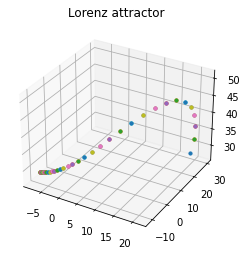

In [16]:
train_model(training_results[3])

KeyError: 'iteration_count'

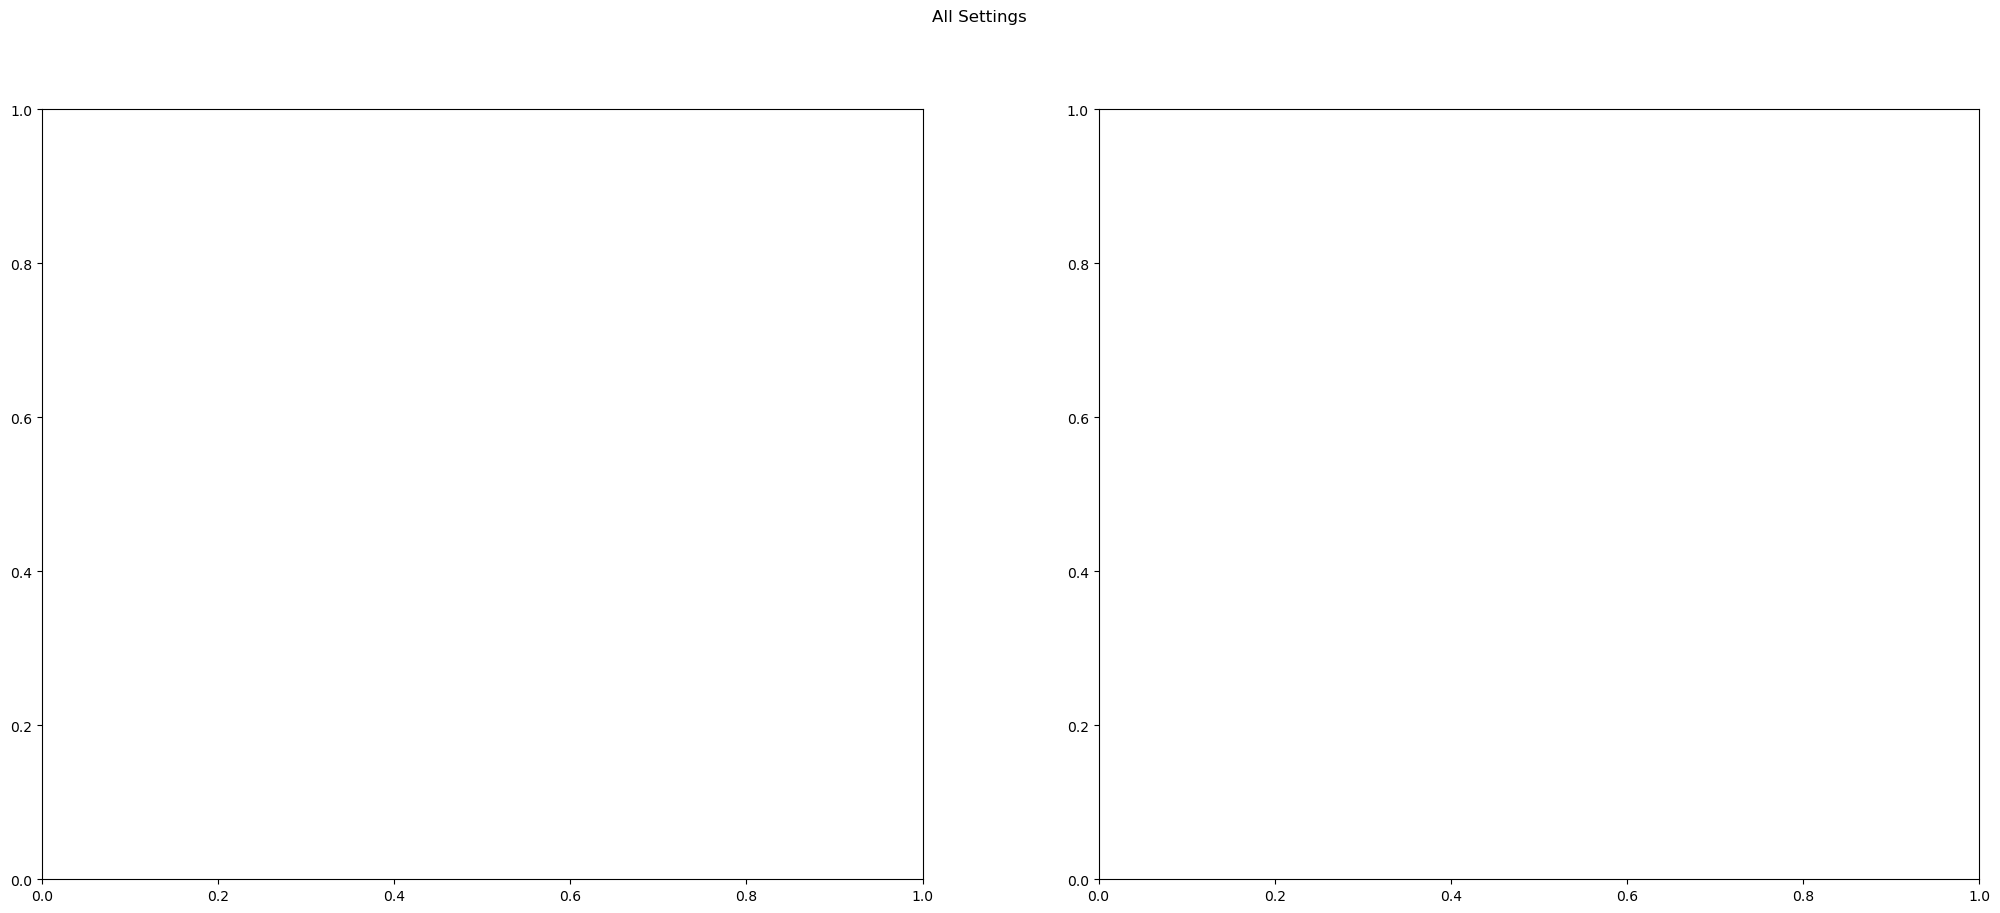

In [155]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

fig.suptitle("All Settings")
x = training_results[0].results["iteration_count"]

ax1.set_title("Rewards")
ax1.set_xlabel("Iteration Count")
ax1.set_ylabel("Average Episodic Reward")

ax2.set_title("Losses")
ax2.set_xlabel("Iteration Count")
ax2.set_ylabel("Average Total Loss")

for training_result in training_results:
    ax1.plot(x, training_result.results["accumulated_rewards"], label=training_result.label)
    ax2.plot(x, training_result.results["total_losses"], label=training_result.label)

ax1.legend()
ax2.legend()
plt.show()